In [1]:
import sys
import os
import glob
import collections
import shutil
import subprocess
import itertools

import numpy as np
import pandas as pd
from scipy import stats

from openeye import oechem

from scipy import stats
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

from textwrap import wrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

%matplotlib inline

%config IPCompleter.greedy=True

In [2]:
np.random.seed(11)

In [3]:
CWD = os.getcwd()

In [4]:
try:
    from pfabnet import base
except ModuleNotFoundError as e:
    os.chdir(os.getcwd() + os.sep + '..')
    
from pfabnet import base

In [5]:
from pfabnet.base import ENTITY_KEY, VISCOSITY_KEY

In [6]:
with open('pfabnet/sbatch_tmpl.sh', 'r') as fptr:
    sbatch_tmpl = fptr.read()
    
print(sbatch_tmpl)

#!/bin/bash -l
#SBATCH -e %j.err
#SBATCH -o %j.out
#SBATCH --nodes=1
#SBATCH --gres=gpu:v100:1
#SBATCH --mem=32gb
#SBATCH --wait



## Training

In [7]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-9\n#SBATCH --time=0-24:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=pfabnet\n\n'
sbatch_script += 'python pfabnet/train.py --training_data_file $1 '
sbatch_script += '--homology_model_dir $2 --output_model_prefix $3 '
sbatch_script += '--output_model_dir $4 --NX $5 --grid_dim $6 --grid_spacing $7 --esp_dir $8 --fold_idx $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_train.sh', 'w') as fptr:
    fptr.write(sbatch_script)

In [8]:
!mkdir -p models
!mkdir -p models/pdgf38
!mkdir -p models/ab21
!mkdir -p models/ab8
!mkdir -p models/loocv

In [9]:
# prepare dataset for LOOCV training
df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_ab21 = pd.read_csv('data/Ab21.csv')

LOOCV_MODELS_DIR = 'models/loocv'
for i, row in df_ab21.iterrows():
    df_test = df_ab21.loc[i:i]
    df_train1 = df_ab21.loc[0:i-1]
    df_train2 = df_ab21.loc[i+1:]
    
    entity = row[ENTITY_KEY]
    df_train = pd.concat([df_pdgf38, df_train1, df_train2])
    df_train.reset_index(drop=True, inplace=True)
    
    dirname = os.path.join(LOOCV_MODELS_DIR, entity)
    os.makedirs(dirname, exist_ok=True)
    
    df_train.to_csv(os.path.join(dirname, 'train.csv'), index=False)
    df_test.to_csv(os.path.join(dirname, 'test.csv'), index=False)
                   

In [10]:
NX = 10
GRID_DIM = 96
GRID_SPACING = 0.75
ESP_DIR = 'data/hm/esp'
with open('train_multi.sh', 'w') as fptr:
    fptr.write('sbatch --export=ALL sbatch_train.sh %s %s %s %s %d %d %.2f %s &\n' % 
               ('data/PDGF38.csv', 'data/hm', 'PfAbNet-PDGF38', 'models/pdgf38', NX, GRID_DIM, GRID_SPACING, ESP_DIR))
    fptr.write('sbatch --export=ALL sbatch_train.sh %s %s %s %s %d %d %.2f %s &\n' % 
               ('data/Ab21.csv', 'data/hm', 'PfAbNet-Ab21', 'models/ab21', NX, GRID_DIM, GRID_SPACING, ESP_DIR))
    
    for row_idx, row in df_ab21.iterrows():
        entity = row[ENTITY_KEY]
        model_output_dir = os.path.join(LOOCV_MODELS_DIR, entity)
        training_data_file = os.path.join(model_output_dir, 'train.csv')
        fptr.write('sbatch --export=ALL sbatch_train.sh %s %s %s %s %d %d %.2f %s &\n' % 
           (training_data_file, 'data/hm', 'PfAbNet-LOOCV', model_output_dir, NX, GRID_DIM, GRID_SPACING, ESP_DIR))
    
    fptr.write('wait\n')
    
!chmod u+rwx train_multi.sh

## Inference

In [11]:
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=predict\n\n'
sbatch_script += 'python pfabnet/predict.py --structure_file $1 '
sbatch_script += '--PfAbNet_model_dir $2 --PfAbNet_model_prefix $3 '
sbatch_script += '--output_file $4 --esp_dir $5 --NX $6 --grid_dim $7 --grid_spacing $8 --shell_width $9\n'

with open('sbatch_predict.sh', 'w') as fptr:
    fptr.write(sbatch_script)

In [167]:
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=predict\n\n'
sbatch_script += 'python pfabnet/predict.py --structure_file $1 '
sbatch_script += '--PfAbNet_model_dir $2 --PfAbNet_model_prefix $3 '
sbatch_script += '--output_file $4 --NX $5 --grid_dim $6 --grid_spacing $7 --shell_width $8\n'

with open('sbatch_predict_Ab8.sh', 'w') as fptr:
    fptr.write(sbatch_script)

In [168]:
ESP_DIR = 'data/hm/esp'
NX = 10
GRID_DIM = 96
GRID_SPACING = 0.75
SHELL_WIDTH = 2.0
with open('predict_multi.sh', 'w') as fptr:
    for row_idx, row in df_ab21.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/pdgf38'
        model_prefix = 'PfAbNet-PDGF38'
        output_file = 'models/pdgf38/%s.csv' % entity
        fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))
    
    df_ab8 = pd.read_csv('data/Ab8.csv')
    for row_idx, row in df_ab8.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/ab21'
        model_prefix = 'PfAbNet-Ab21'
        output_file = 'models/ab21/%s.csv' % entity
        fptr.write('sbatch --export=ALL sbatch_predict_Ab8.sh %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH)) 
    
    for row_idx, row in df_pdgf38.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/ab21'
        model_prefix = 'PfAbNet-Ab21'
        output_file = 'models/ab21/%s.csv' % entity
        fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))   
    
    for row_idx, row in df_ab21.iterrows():
        entity = row[ENTITY_KEY]
        structure_file = 'data/hm/%s.mol2' % entity
        model_dir = 'models/loocv/%s' % entity
        model_prefix = 'PfAbNet-LOOCV'
        output_file = 'models/loocv/%s/%s.csv' % (entity, entity)
        fptr.write('sbatch --export=ALL sbatch_predict.sh %s %s %s %s %s %d %d %.2f %.1f &\n' 
                   % (structure_file, model_dir, model_prefix, output_file, ESP_DIR, 
                      NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))
    
    fptr.write('wait\n')
    
!chmod u+rwx predict_multi.sh
#!./predict_multi.sh

In [13]:
SCM_SCORE_KEY = 'SCM_score'
SHARMA_SCORE_KEY = 'Sharma_score'
PfAbNet_SCORE_KEY = 'VISCOSITY_PRED'
VISCOSITY_MES = VISCOSITY_KEY

FONT_SIZE = 20

In [14]:
eisenberg_scale_hyd = collections.defaultdict(float)
eisenberg_scale_hyd['ALA'] = 0.25; eisenberg_scale_hyd['CYS'] = 0.04; eisenberg_scale_hyd['PHE'] = 0.61;
eisenberg_scale_hyd['ILE'] = 0.73; eisenberg_scale_hyd['LEU'] = 0.53; eisenberg_scale_hyd['PRO'] = -0.07;
eisenberg_scale_hyd['VAL'] = 0.54; eisenberg_scale_hyd['TRP'] = 0.37; eisenberg_scale_hyd['TYR'] = 0.02;

eisenberg_scale_philic = collections.defaultdict(float)
eisenberg_scale_philic['ASP'] = -0.72; eisenberg_scale_philic['GLU'] = -0.62; eisenberg_scale_philic['GLY'] = 0.16; 
eisenberg_scale_philic['HIS'] = -0.40; eisenberg_scale_philic['LYS'] = -1.1; eisenberg_scale_philic['MET'] = 0.26;
eisenberg_scale_philic['ASN'] = -0.64; eisenberg_scale_philic['GLN'] = -0.69; eisenberg_scale_philic['ARG'] = -1.8;
eisenberg_scale_philic['SER'] = -0.26; eisenberg_scale_philic['THR'] = -0.18; 

def get_sharma_descriptors_base(mol):
    q = 0
    hv = oechem.OEHierView(mol)
    q_chain = collections.defaultdict(float)
    qsym = 0

    HI_hyd = 0.0; HI_philic = 0.0
    chain_ids = []
    for hr in hv.GetResidues():
        res = hr.GetOEResidue()
        aa = hr.GetResidueName()
        chain_id = res.GetChainID()
        if chain_id not in chain_ids:
            chain_ids.append(chain_id)
            
        if aa in ['ARG', 'LYS']:
            q_chain[chain_id] += 1
            q += 1
        if aa in ['ASP', 'GLU']:
            q_chain[chain_id] -= 1
            q -= 1
            
        HI_hyd += eisenberg_scale_hyd[aa]
        HI_philic += eisenberg_scale_philic[aa]
        
    HI = HI_hyd / HI_philic
        
    qsym = q_chain[chain_ids[0]] * q_chain[chain_ids[1]]

    return q, qsym, HI


def get_sharma_descriptors(file_pattern):
    mol2_files = glob.glob(file_pattern)
    data = []
    for f in mol2_files:
        ifs = oechem.oemolistream(f)
        mol = oechem.OEGraphMol()
        oechem.OEReadMolecule(ifs, mol)
        ifs.close()
        
        oechem.OEPerceiveResidues(mol)
        try:
            q, qsym, HI = get_sharma_descriptors_base(mol)
            mol_id = os.path.basename(f).split('.')[0]
            data.append((mol_id, q, qsym, HI))
        except Exception as e:
            pass
        
    df = pd.DataFrame(data, columns=[ENTITY_KEY, 'q', 'qsym', 'HI'])
    
    return df


def calc_sharma_score(df_train, df_test):
    y_train = df_train[VISCOSITY_KEY].values
    X_train = df_train[['q', 'qsym', 'HI']].values   
    
    X_test = df_test[['q', 'qsym', 'HI']].values
    
    reg = LinearRegression().fit(X_train, np.log10(y_train))
    ypred = np.power(10, reg.predict(X_test))

    df_test.insert(len(df_test.columns), SHARMA_SCORE_KEY, ypred)
    
    return df_test
    

In [15]:
def plot_confusion_matrix(axs, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, predicted_classes=None, show_xlabel=True, show_ylabel=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    font_size = 20
    
    axs.imshow(cm, interpolation='nearest', cmap=cmap)

    if predicted_classes is None:
        predicted_classes = classes
    
    tick_marks = np.arange(len(classes))
    axs.set_xticks(tick_marks)
    axs.set_xticklabels(predicted_classes, fontsize=font_size)
    axs.yaxis.tick_right()
    axs.set_yticks(tick_marks)
    axs.set_yticklabels(classes, rotation=90, fontsize=font_size, va='center')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axs.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=font_size,
                 color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    if show_ylabel:
        axs.set_ylabel('Measured', fontsize=font_size)
    if show_xlabel:
        axs.set_xlabel('Predicted', fontsize=font_size)
    
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    opt_operating_pt = list(roc_t['threshold'])
    return opt_operating_pt[0]


def find_optimal_cutoff2(ytest, ypred):
    ytest_class = ytest.copy()
    ytest_class[ytest_class<20] = 0
    ytest_class[ytest_class>=20] = 1

    thres = Find_Optimal_Cutoff(ytest_class, ypred)
    
    return thres

def generate_and_plot_confusion_matrix(axs, ytest, ypred, label):
    ytest_class = ytest.copy()
    ytest_class[ytest_class<=20] = 0
    ytest_class[ytest_class>20] = 1

    thres = Find_Optimal_Cutoff(ytest_class, ypred)
    print('Optimal operating point', thres)
    ypred_class = ypred.copy()
    ypred_class[ypred_class<=thres] = 0
    ypred_class[ypred_class>thres] = 1


    cnf_matrix = confusion_matrix(ytest_class, ypred_class)
    np.set_printoptions(precision=2)

    axs.text(-0.08, 0.96, label, transform=axs.transAxes, fontsize=FONT_SIZE)
    # Plot non-normalized confusion matrix
    classes = ['Non-viscous', 'Viscous']
    plot_confusion_matrix(axs, cnf_matrix, 
                          classes=classes, title='test')

## Plot performance

In [16]:
def retrieve_prediction_outputs(file_pattern):
    pred_files = glob.glob(file_pattern)
    df_list = []
    for pred_file in pred_files:
        df = pd.read_csv(pred_file)
        df_list.append(df)

    df = pd.concat(df_list)

    return df

In [74]:
def calc_auc(y_mes, y_pred, class_threshold=20):
    y_binary = np.copy(y_mes)
    y_binary[y_binary<=class_threshold] = 0; y_binary[y_binary>class_threshold] = 1
    auc = roc_auc_score(y_binary, y_pred)  
    
    return auc, y_binary
    
def generate_parity_plot(ax, x, y, label):
    ax.scatter(x, y)
    rho = stats.spearmanr(x, y).correlation
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r2_value = r_value ** 2
    ax.text(0.07, 0.85, r'$\rho=%.2f$, $R^2=%.2f$'%(rho, r2_value), transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.set_xlabel('Measured (cP)', fontsize=FONT_SIZE)
    ax.set_ylabel('Prediction (cP)', fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)


def generate_roc_plot(ax, y_mes, y_pred, label, class_threshold=20):
    auc, y_binary = calc_auc(y_mes, y_pred, class_threshold)
    fpr, tpr, _ = roc_curve(y_binary, y_pred)
    ax.plot(fpr, tpr)
    ax.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
    ax.set_xlabel('False positive rate', fontsize=FONT_SIZE)
    ax.set_ylabel('True positive rate', fontsize=FONT_SIZE)
    ax.text(0.07, 0.9, 'AUC=%.2f'%auc, fontsize=FONT_SIZE)
    ax.text(0.05, 0.93, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    

YLIM_LOW = 0.32


def bar_plot(ax, x, tick_labels, label, ylabel, ylim_low=0.32, ylim_high=1.0,
             xlabel_rot=0, label_loc_x=0.85, label_loc_y=0.93):
    ax.set_ylim([ylim_low, ylim_high])
    ax.set_xticks(x)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.set_xticklabels(tick_labels, fontsize=FONT_SIZE, rotation=xlabel_rot)
    ax.text(label_loc_x, label_loc_y, label, transform=ax.transAxes, fontsize=FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
    

BAR_XTICK_LABELS = ['Sharma', 'SCM', 'PfAbNet']

def generate_bootstrap_auc(y, ypred):
    auc = []
    for i in range(500):
        y1, ypred1 = resample(y, ypred)
        try:
            auc1, _ = calc_auc(y1, ypred1)
            auc.append(auc1)
        except Exception as e:
            pass

    auc = np.array(auc)
    
    return auc

def calc_auc_se(df):
    def cal_stderror_auc(y, ypred):
        auc = generate_bootstrap_auc(y, ypred)
        se = 1.96*np.std(auc)/np.sqrt(len(y))

        return se

    auc_pfabnet, _ = calc_auc(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    se_auc_pfabnet = cal_stderror_auc(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    
    auc_sharma, _ = calc_auc(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    se_auc_sharma = cal_stderror_auc(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    
    auc_scm, _ = calc_auc(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    se_auc_scm = cal_stderror_auc(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    print('AUC: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (auc_pfabnet, auc_sharma, auc_scm))
    print('AUC SE: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (se_auc_pfabnet, se_auc_sharma, se_auc_scm))
    
    return auc_sharma, auc_scm, auc_pfabnet, se_auc_sharma, se_auc_scm, se_auc_pfabnet
    

def generate_bootstrap_spearmanr(y, ypred):
    r = []
    for i in range(500):
        y1, ypred1 = resample(y, ypred)
        r.append(stats.spearmanr(y1, ypred1).correlation)

    r = np.array(r)

    return r
    
def calc_spearmann_corr(df):
    def cal_stderror_spearmanr(y, ypred):
        r = generate_bootstrap_spearmanr(y, ypred)
        se = 1.96*np.std(r)/np.sqrt(len(y))

        return se

    slope, intercept, r_value, p_value, std_err = stats.linregress(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    rho_pfabnet = r_value ** 2
    rho_pfabnet = stats.spearmanr(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY]).correlation
    rho_se_pfabnet = cal_stderror_spearmanr(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    rho_sharma = r_value ** 2
    rho_sharma = stats.spearmanr(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY]).correlation
    rho_se_sharma = cal_stderror_spearmanr(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    rho_scm = r_value ** 2
    rho_scm = stats.spearmanr(df[VISCOSITY_KEY], df[SCM_SCORE_KEY]).correlation
    rho_se_scm = cal_stderror_spearmanr(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    
    print('Spearmann R: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (rho_pfabnet, rho_sharma, rho_scm))
    print('Spearmann SE: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (rho_se_pfabnet, rho_se_sharma, rho_se_scm))

    return rho_sharma, rho_scm, rho_pfabnet, rho_se_sharma, rho_se_scm, rho_se_pfabnet
    
    
def plot_corr_auc(ax, df, label, show_legend=True):
    rho_sharma, rho_scm, rho_pfabnet, rho_se_sharma, rho_se_scm, rho_se_pfabnet = calc_spearmann_corr(df)
    r_squared_sharma, r_squared_scm, r_squared_pfabnet, r2_se_sharma, r2_se_scm, r2_se_pfabnet = calc_r_squared(df)
    auc_sharma, auc_scm, auc_pfabnet, se_auc_sharma, se_auc_scm, se_auc_pfabnet = calc_auc_se(df)
    
    width = 0.2
    x = np.arange(3)
    ax.bar(x - width, [rho_sharma, rho_scm, rho_pfabnet], width, yerr=[rho_se_sharma, rho_se_scm, rho_se_pfabnet], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.bar(x, [r_squared_sharma, r_squared_scm, r_squared_pfabnet], width, 
           yerr=[r2_se_sharma, r2_se_scm, r2_se_pfabnet], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.bar(x + width, [auc_sharma, auc_scm, auc_pfabnet], width, 
           yerr=[se_auc_sharma, se_auc_scm, se_auc_pfabnet], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
    
    if show_legend:
        ax.legend([r'$\rho$', r'$R^2$', 'ROC-AUC'], fontsize=FONT_SIZE) 
        
    bar_plot(ax, x, BAR_XTICK_LABELS, label, 'Performance')

    
def generate_bootstrap_r_squared(y, ypred):
    r = []
    for i in range(500):
        y1, ypred1 = resample(y, ypred)
        _, _, r_value, _, _ = stats.linregress(y1, ypred1)
        r.append(r_value ** 2)

    r = np.array(r)

    return r
    
    
def calc_r_squared(df):
    def cal_stderror_r_squared(y, ypred):
        r = generate_bootstrap_r_squared(y, ypred)
        se = 1.96*np.std(r)/np.sqrt(len(y))

        return se

    _, _, r_value, _, _ = stats.linregress(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    r_squared_pfabnet = r_value ** 2
    se_pfabnet = cal_stderror_r_squared(df[VISCOSITY_KEY], df[PfAbNet_SCORE_KEY])
    
    _, _, r_value, _, _ = stats.linregress(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    r_squared_sharma = r_value ** 2
    se_sharma = cal_stderror_r_squared(df[VISCOSITY_KEY], df[SHARMA_SCORE_KEY])
    
    _, _, r_value, _, _ = stats.linregress(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    r_squared_scm = r_value ** 2
    se_scm = cal_stderror_r_squared(df[VISCOSITY_KEY], df[SCM_SCORE_KEY])
    
    print(r'$R^2$: PfAbNet: %.2f, Sharma: %.2f, SCM: %.2f' % (r_squared_pfabnet, r_squared_sharma, r_squared_scm))
    print(r'$R^2$ SE: PfAbNet: %.2E, Sharma: %.2E, SCM: %.2E' % (se_pfabnet, se_sharma, se_scm))
    
    return r_squared_sharma, r_squared_scm, r_squared_pfabnet, se_sharma, se_scm, se_pfabnet
    

In [18]:
df_sharma_desc = get_sharma_descriptors('data/hm/*.pdb')

In [19]:
df_pred = retrieve_prediction_outputs('models/pdgf38//*.csv')
df_ab21_pred = df_ab21.merge(df_pred, on=ENTITY_KEY)
df_ab21_pred[SCM_SCORE_KEY] = df_ab21_pred['SCM Fv']
df_ab21_pred = df_ab21_pred.merge(df_sharma_desc, on=ENTITY_KEY)

df_pred = retrieve_prediction_outputs('models/ab21//*.csv')
df_pdgf38_pred = df_pdgf38.merge(df_pred, on=ENTITY_KEY)
df_pdgf38_pred.loc[df_pdgf38_pred[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
df_pdgf38_pred[SCM_SCORE_KEY] = -df_pdgf38_pred['SCM']
df_pdgf38_pred = df_pdgf38_pred.merge(df_sharma_desc, on=ENTITY_KEY)

# df_pred = retrieve_prediction_outputs('models/ab21//*.csv')
# df_ab8_pred = df_ab8.merge(df_pred, on=ENTITY_KEY)
# df_ab8_pred.loc[df_ab8_pred[VISCOSITY_MES] > 1000, VISCOSITY_MES] = 1000
# df_ab8_pred[SCM_SCORE_KEY] = -df_ab8_pred['SCM']
# df_ab8_pred = df_ab8_pred.merge(df_sharma_desc, on=ENTITY_KEY)

df_ab21_pred = calc_sharma_score(df_pdgf38_pred, df_ab21_pred)
df_pdgf38_pred = calc_sharma_score(df_ab21_pred, df_pdgf38_pred)
# df_ab8_pred = calc_sharma_score(df_ab21_pred, df_ab8_pred)

In [20]:
df_loocv_train = pd.concat([df_pdgf38_pred, df_ab21_pred])
df_loocv_train.drop(PfAbNet_SCORE_KEY, inplace=True, axis=1)

df_pred = retrieve_prediction_outputs('models/loocv/*/mAb*.csv')
df_loocv_pred = df_ab21.merge(df_pred, on=ENTITY_KEY)
df_loocv_pred[SCM_SCORE_KEY] = df_loocv_pred['SCM Fv']
df_loocv_pred = df_loocv_pred.merge(df_sharma_desc, on=ENTITY_KEY)

df_loocv_preds = []
for entity in df_loocv_pred[ENTITY_KEY].values:
    df_train = df_loocv_train.loc[~(df_loocv_train[ENTITY_KEY] == entity), :]
    df_test = df_loocv_pred.loc[df_loocv_pred[ENTITY_KEY] == entity, :]
    df_loocv_pred2 = calc_sharma_score(df_train, df_test)
    df_loocv_preds.append(df_loocv_pred2)
    
df_loocv_pred = pd.concat(df_loocv_preds)

Optimal operating point 22.33
Confusion matrix, without normalization
[[ 4  0]
 [ 8 26]]
Spearmann R: PfAbNet: 0.80, Sharma: 0.67, SCM: 0.75
Spearmann SE: PfAbNet: 0.02, Sharma: 0.02, SCM: 0.02
$R^2$: PfAbNet: 0.62, Sharma: 0.49, SCM: 0.60
$R^2$ SE: PfAbNet: 2.17E-02, Sharma: 3.35E-02, SCM: 3.16E-02
AUC: PfAbNet: 0.84, Sharma: 0.73, SCM: 0.80
AUC SE: PfAbNet: 0.02, Sharma: 0.03, SCM: 0.02
Optimal operating point 71.80046586811254
Confusion matrix, without normalization
[[10  3]
 [ 2  6]]
Spearmann R: PfAbNet: 0.75, Sharma: 0.65, SCM: 0.49
Spearmann SE: PfAbNet: 0.06, Sharma: 0.07, SCM: 0.08
$R^2$: PfAbNet: 0.75, Sharma: 0.64, SCM: 0.40
$R^2$ SE: PfAbNet: 7.67E-02, Sharma: 1.02E-01, SCM: 7.50E-02
AUC: PfAbNet: 0.82, Sharma: 0.78, SCM: 0.63
AUC SE: PfAbNet: 0.04, Sharma: 0.05, SCM: 0.06
Optimal operating point 32.71614792429025
Confusion matrix, without normalization
[[9 4]
 [3 5]]
Spearmann R: PfAbNet: 0.71, Sharma: 0.55, SCM: 0.49
Spearmann SE: PfAbNet: 0.06, Sharma: 0.07, SCM: 0.07
$R

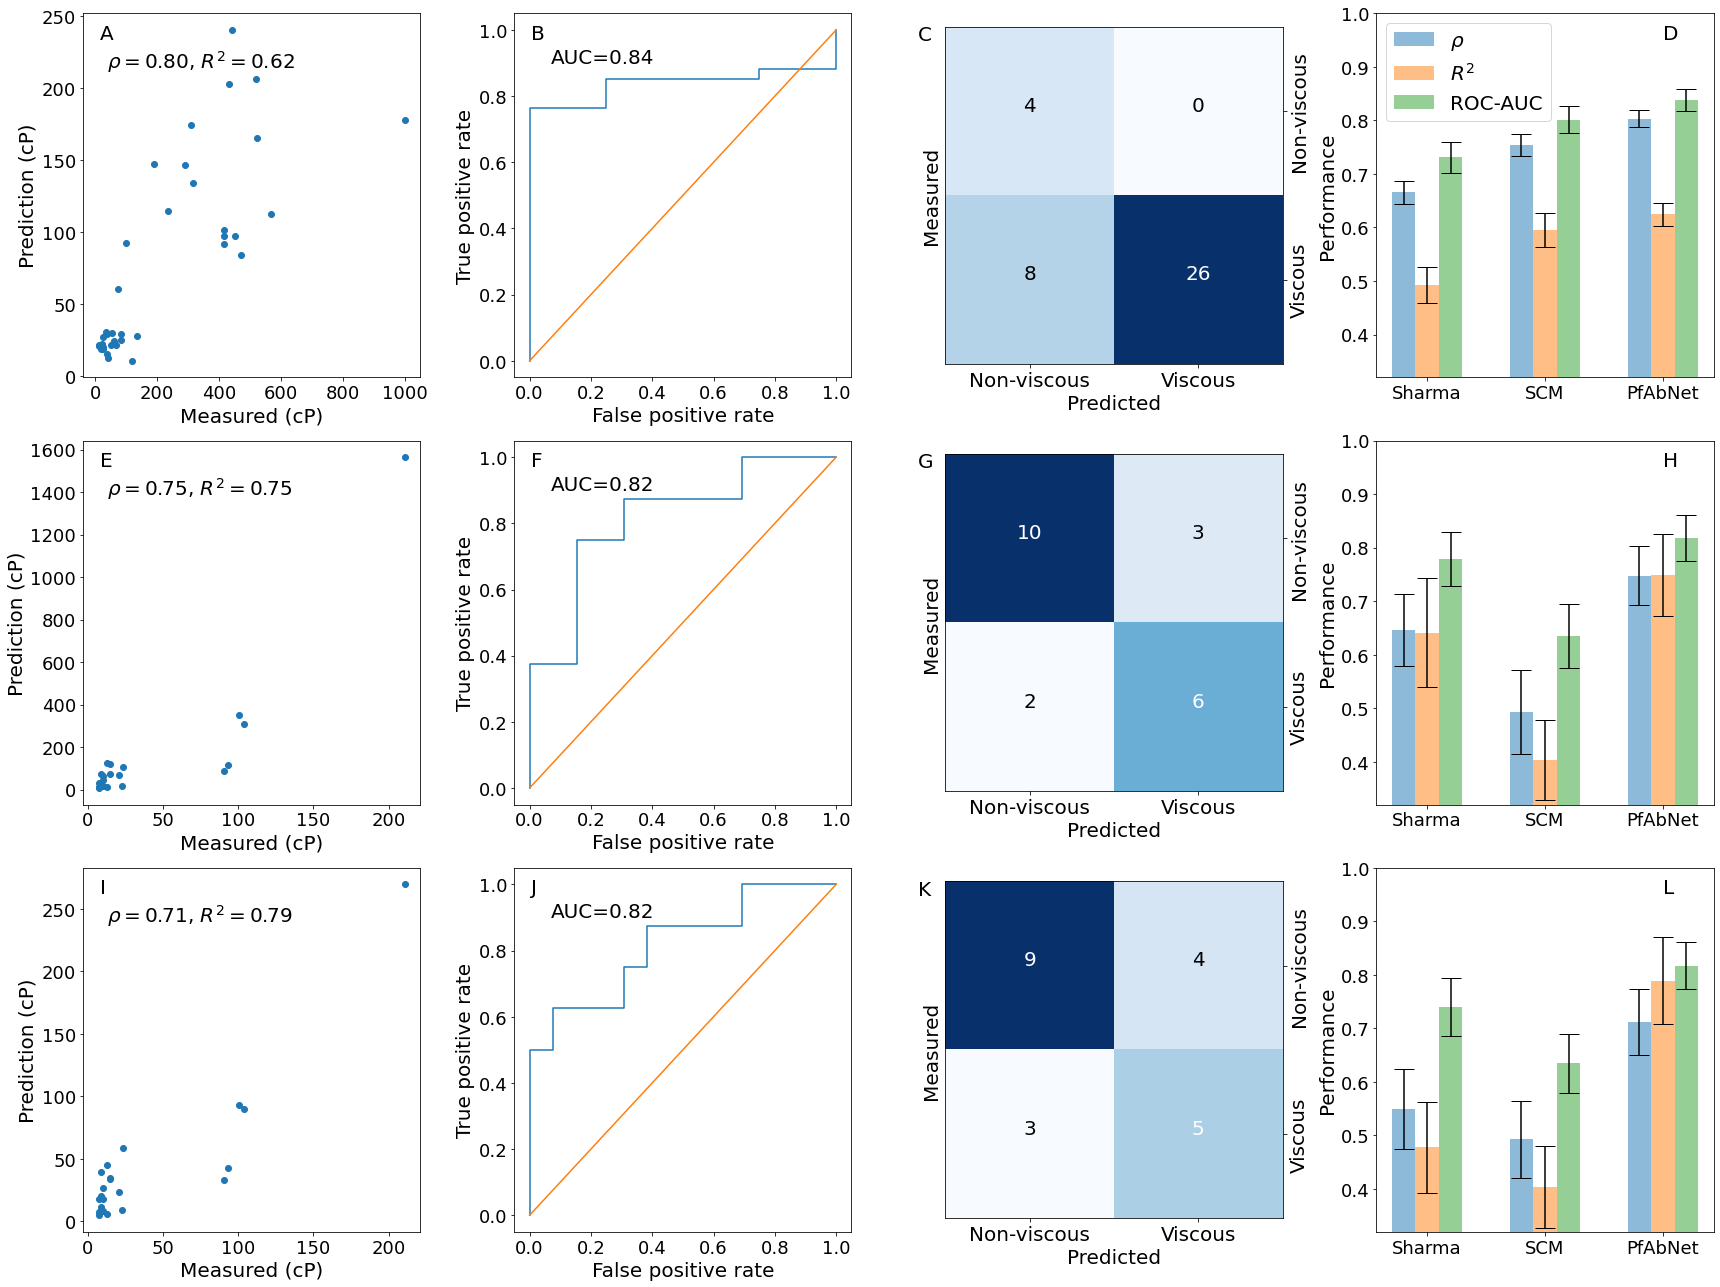

In [108]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols,6*nrows))

np.random.seed(11)

generate_parity_plot(axs[0,0], df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 'A')
generate_roc_plot(axs[0,1], df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 'B')
generate_and_plot_confusion_matrix(axs[0,2], df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 'C')
plot_corr_auc(axs[0,3], df_pdgf38_pred, 'D')

generate_parity_plot(axs[1,0], df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 'E')
generate_roc_plot(axs[1,1], df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 'F')
generate_and_plot_confusion_matrix(axs[1,2], df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 'G')
plot_corr_auc(axs[1,3], df_ab21_pred, 'H', False)

generate_parity_plot(axs[2,0], df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 'I')
generate_roc_plot(axs[2,1], df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 'J')
generate_and_plot_confusion_matrix(axs[2,2], df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 'K')
plot_corr_auc(axs[2,3], df_loocv_pred, 'L', False)

plt.tight_layout()

plt.savefig('Fig2.png', bbox_inches='tight', dpi=300)

### p-value: PfAbNet Spearmann R vs Sharma and PfAbNet Spearmann R vs SCM

In [25]:
def cal_ttest_pvalue_spearmannR(x1, y1, x2, y2):
    rho1 = generate_bootstrap_spearmanr(x1, y1)
    rho2 = generate_bootstrap_spearmanr(x2, y2)
    
    ttest = stats.ttest_ind(rho1, rho2)
    return ttest.pvalue

def cal_ttest_pvalue_r_squared(x1, y1, x2, y2):
    r2_1 = generate_bootstrap_r_squared(x1, y1)
    r2_2 = generate_bootstrap_r_squared(x2, y2)
    
    ttest = stats.ttest_ind(r2_1, r2_2)
    return ttest.pvalue
    
def cal_ttest_pvalue_auc(x1, y1, x2, y2):
    auc1 = generate_bootstrap_auc(x1, y1)
    auc2 = generate_bootstrap_auc(x2, y2)
    
    ttest = stats.ttest_ind(auc1, auc2)
    return ttest.pvalue

In [26]:
np.random.seed(11)
pfabnet_vs_sharma_r_pdgf38 = cal_ttest_pvalue_spearmannR(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                       df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_r_pdgf38 = cal_ttest_pvalue_spearmannR(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                    df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[SCM_SCORE_KEY])

pfabnet_vs_sharma_r_ab21 = cal_ttest_pvalue_spearmannR(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                       df_ab21_pred[VISCOSITY_MES], df_ab21_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_r_ab21 = cal_ttest_pvalue_spearmannR(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                    df_ab21_pred[VISCOSITY_MES], df_ab21_pred[SCM_SCORE_KEY])

pfabnet_vs_sharma_r_loocv = cal_ttest_pvalue_spearmannR(df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 
                                                       df_loocv_pred[VISCOSITY_MES], df_loocv_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_r_loocv = cal_ttest_pvalue_spearmannR(df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 
                                                    df_loocv_pred[VISCOSITY_MES], df_loocv_pred[SCM_SCORE_KEY])

print('p-value PDGF38 - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_r_pdgf38)
print('p-value PDGF38 - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_r_pdgf38)
print('p-value Ab21 - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_r_ab21)
print('p-value Ab21 - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_r_ab21)
print('p-value LOOCV - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_r_loocv)
print('p-value LOOCV - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_r_loocv)

p-value PDGF38 - PfAbNet vs. Sharma: 2e-203
p-value PDGF38 - PfAbNet vs. SCM: 5e-39
p-value Ab21 - PfAbNet vs. Sharma: 1e-25
p-value Ab21 - PfAbNet vs. SCM: 2e-99
p-value LOOCV - PfAbNet vs. Sharma: 2e-60
p-value LOOCV - PfAbNet vs. SCM: 5e-79


In [27]:
np.random.seed(11)
pfabnet_vs_sharma_r2_pdgf38 = cal_ttest_pvalue_r_squared(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                       df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_r2_pdgf38 = cal_ttest_pvalue_r_squared(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                    df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[SCM_SCORE_KEY])

pfabnet_vs_sharma_r2_ab21 = cal_ttest_pvalue_r_squared(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                       df_ab21_pred[VISCOSITY_MES], df_ab21_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_r2_ab21 = cal_ttest_pvalue_r_squared(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                    df_ab21_pred[VISCOSITY_MES], df_ab21_pred[SCM_SCORE_KEY])

pfabnet_vs_sharma_r2_loocv = cal_ttest_pvalue_r_squared(df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 
                                                       df_loocv_pred[VISCOSITY_MES], df_loocv_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_r2_loocv = cal_ttest_pvalue_r_squared(df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 
                                                    df_loocv_pred[VISCOSITY_MES], df_loocv_pred[SCM_SCORE_KEY])

print('p-value PDGF38 - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_r2_pdgf38)
print('p-value PDGF38 - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_r2_pdgf38)
print('p-value Ab21 - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_r2_ab21)
print('p-value Ab21 - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_r2_ab21)
print('p-value LOOCV - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_r2_loocv)
print('p-value LOOCV - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_r2_loocv)

p-value PDGF38 - PfAbNet vs. Sharma: 2e-83
p-value PDGF38 - PfAbNet vs. SCM: 5e-02
p-value Ab21 - PfAbNet vs. Sharma: 2e-25
p-value Ab21 - PfAbNet vs. SCM: 6e-141
p-value LOOCV - PfAbNet vs. Sharma: 7e-78
p-value LOOCV - PfAbNet vs. SCM: 1e-107


In [28]:
np.random.seed(11)
pfabnet_vs_sharma_auc_pdgf38 = cal_ttest_pvalue_auc(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                    df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_auc_pdgf38 = cal_ttest_pvalue_auc(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                 df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[SCM_SCORE_KEY])

pfabnet_vs_sharma_auc_ab21 = cal_ttest_pvalue_auc(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                df_ab21_pred[VISCOSITY_MES], df_ab21_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_auc_ab21 = cal_ttest_pvalue_auc(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY], 
                                             df_ab21_pred[VISCOSITY_MES], df_ab21_pred[SCM_SCORE_KEY])

pfabnet_vs_sharma_auc_loocv = cal_ttest_pvalue_auc(df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 
                                                    df_loocv_pred[VISCOSITY_MES], df_loocv_pred[SHARMA_SCORE_KEY])
pfabnet_vs_scm_auc_loocv = cal_ttest_pvalue_auc(df_loocv_pred[VISCOSITY_MES], df_loocv_pred[PfAbNet_SCORE_KEY], 
                                                 df_loocv_pred[VISCOSITY_MES], df_loocv_pred[SCM_SCORE_KEY])

print('p-value PDGF38 - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_auc_pdgf38)
print('p-value PDGF38 - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_auc_pdgf38)
print('p-value Ab21 - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_auc_ab21)
print('p-value Ab21 - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_auc_ab21)
print('p-value LOOCV - PfAbNet vs. Sharma: %.e' % pfabnet_vs_sharma_auc_loocv)
print('p-value LOOCV - PfAbNet vs. SCM: %.e' % pfabnet_vs_scm_auc_loocv)

p-value PDGF38 - PfAbNet vs. Sharma: 9e-96
p-value PDGF38 - PfAbNet vs. SCM: 1e-19
p-value Ab21 - PfAbNet vs. Sharma: 8e-05
p-value Ab21 - PfAbNet vs. SCM: 2e-98
p-value LOOCV - PfAbNet vs. Sharma: 1e-24
p-value LOOCV - PfAbNet vs. SCM: 7e-95


### Classification performance: PfAbNet vs. the baseline (null model)

In [157]:
def get_bootstrap_accuracy(y_mes, y_pred, y_mes_threshold=20, y_pred_threshold=20, n_bootstrap=500):
    bootstrap_accuracy = []
    for i in range(n_bootstrap):
        y1, ypred1 = resample(y_mes, y_pred)
        accuracy1 = calc_accuracy(y1, ypred1, y_mes_threshold, y_pred_threshold)
        bootstrap_accuracy.append(accuracy1)

    bootstrap_accuracy = np.array(bootstrap_accuracy)
    
    return bootstrap_accuracy

    
def calc_stderr_accuracy(y_mes, y_pred, y_mes_threshold=20, y_pred_threshold=20):
    bootstrap_accuracy = get_bootstrap_accuracy(y_mes, y_pred, y_mes_threshold, y_pred_threshold)
    se = 1.96*np.std(bootstrap_accuracy)/np.sqrt(len(y_mes))

    return se, bootstrap_accuracy

def calc_accuracy(y_mes, y_pred, y_mes_threshold=20, y_pred_threshold=20):
    y_mes_binary = np.copy(y_mes)
    y_mes_binary[y_mes_binary<=y_mes_threshold] = 0; y_mes_binary[y_mes_binary>y_mes_threshold] = 1
    
    y_pred_binary = np.copy(y_pred)
    y_pred_binary[y_pred_binary<=y_pred_threshold] = 0; y_pred_binary[y_pred_binary>y_pred_threshold] = 1    
    
    accuracy = 1.0 - np.sum(np.abs(y_mes_binary - y_pred_binary))/len(y_mes)
    
    return 100*accuracy

def calc_accuracy_se(y_mes, y_pred, y_mes_threshold=20, y_pred_threshold=20):
    accuracy = calc_accuracy(y_mes, y_pred, y_mes_threshold, y_pred_threshold)
    se, bootstrap_accuracy = calc_stderr_accuracy(y_mes, y_pred, y_mes_threshold, y_pred_threshold)
    
    return accuracy, se, bootstrap_accuracy
    
def calc_balanced_accuracy_se(y_mes, y_pred, y_mes_threshold=20, y_pred_threshold=20, class_ratio=1.0):
    y_mes_low = y_mes[y_mes <= y_mes_threshold]
    y_pred_low = y_pred[y_mes <= y_mes_threshold]
    y_mes_high = y_mes[y_mes > y_mes_threshold]
    y_pred_high = y_pred[y_mes > y_mes_threshold]
    
    n_samples = len(y_mes_low) if len(y_mes_low) < len(y_mes_high) else len(y_mes_high)
    n_samples *= class_ratio
    
    accuracy_list, se_list, bootstrap_accuracy_list = [], [], []
    for i in range(50):
        if len(y_mes_low) > n_samples:
            y_mes_low2, y_pred_low2 = resample(y_mes_low, y_pred_low, replace=True, n_samples=n_samples)
        else:
            y_mes_low2, y_pred_low2 = y_mes_low, y_pred_low
            
        if len(y_mes_high) > n_samples:
            y_mes_high2, y_pred_high2 = resample(y_mes_high, y_pred_high, replace=True, n_samples=n_samples)
        else:
            y_mes_high2, y_pred_high2 = y_mes_high, y_pred_high        
            
        # print(len(y_mes_low2), len(y_mes_high2), len(y_pred_low2), len(y_pred_high2))
        # print(y_mes_low2)
        # print(y_mes_high2)
        y_mes2 = np.concatenate([y_mes_low2, y_mes_high2])
        y_pred2 = np.concatenate([y_pred_low2, y_pred_high2])
        
        accuracy = calc_accuracy(y_mes2, y_pred2, y_mes_threshold, y_pred_threshold)
        se, bootstrap_accuracy = calc_stderr_accuracy(y_mes2, y_pred2, y_mes_threshold, y_pred_threshold)
        accuracy_list.append(accuracy)
        se_list.append(se)
        bootstrap_accuracy_list.append(bootstrap_accuracy)
    
    
    return np.mean(np.array(accuracy_list)), np.mean(np.array(se)), bootstrap_accuracy_list


In [164]:
def plot_pfabnet_vs_baseline_accuracy(ax, label, class_threshold = 20, show_legend = False):
    opt_threshold = find_optimal_cutoff2(df_pdgf38_pred[VISCOSITY_MES], df_pdgf38_pred[PfAbNet_SCORE_KEY])
    pdgf38_pfabnet_acc, pdgf38_pfabnet_acc_se, pdgf38_pfabnet_acc_boots = calc_accuracy_se(df_pdgf38_pred[VISCOSITY_MES], 
                                                                                         df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                                                         y_mes_threshold=class_threshold,
                                                                                         y_pred_threshold=opt_threshold)
    print('Optimal threshold: %.1f\nPfAbNet PDGF38 accuracy: %.2f, stderr: %.2f' % (opt_threshold, pdgf38_pfabnet_acc, pdgf38_pfabnet_acc_se))

    pdgf38_null_model_acc, pdgf38_null_model_acc_se, pdgf38_null_model_acc_boots = calc_accuracy_se(df_pdgf38_pred[VISCOSITY_MES], 
                                                                                                   df_pdgf38_pred[PfAbNet_SCORE_KEY], 
                                                                                                   y_mes_threshold=class_threshold,
                                                                                                   y_pred_threshold=-1)
    print('Null model PDGF38 accuracy: %.2f, stderr: %.2f' % (pdgf38_null_model_acc, pdgf38_null_model_acc_se))
    ttest = stats.ttest_ind(pdgf38_pfabnet_acc_boots, pdgf38_null_model_acc_boots)
    print('p-value: %.e' % ttest.pvalue)
    
    opt_threshold = find_optimal_cutoff2(df_pdgf38_ab8_pred[VISCOSITY_MES], df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY])
    pdgf38_ab8_pfabnet_acc, pdgf38_ab8_pfabnet_acc_se, pdgf38_ab8_pfabnet_acc_boots = calc_accuracy_se(df_pdgf38_ab8_pred[VISCOSITY_MES], 
                                                                                                     df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 
                                                                                                     y_mes_threshold=class_threshold,
                                                                                                     y_pred_threshold=opt_threshold)
    print('Optimal threshold: %.1f\nPfAbNet PDGF38_Ab8 accuracy: %.2f, stderr: %.2f' % (opt_threshold, pdgf38_ab8_pfabnet_acc, pdgf38_ab8_pfabnet_acc_se))

    pdgf38_ab8_null_model_acc, pdgf38_ab8_null_model_acc_se, pdgf38_ab8_null_model_acc_boots = calc_accuracy_se(df_pdgf38_ab8_pred[VISCOSITY_MES], 
                                                                                                               df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 
                                                                                                               y_mes_threshold=class_threshold,
                                                                                                               y_pred_threshold=-1)
    print('Null model PDGF38_Ab8 accuracy: %.2f, stderr: %.2f' % (pdgf38_ab8_null_model_acc, pdgf38_ab8_null_model_acc_se))
    ttest = stats.ttest_ind(pdgf38_ab8_pfabnet_acc_boots, pdgf38_ab8_null_model_acc_boots)
    print('p-value: %.e' % ttest.pvalue)
    
    # ceate a balanced set 2:1 - 2 from the high-viscosity class, 1 from the low-viscosity class
    class_ratio = 2
    pdgf38_ab8_pfabnet_acc2, pdgf38_ab8_pfabnet_acc_se2, pdgf38_ab8_pfabnet_acc_boots2 = calc_balanced_accuracy_se(df_pdgf38_ab8_pred[VISCOSITY_MES], 
                                                                                                                 df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 
                                                                                                                 y_mes_threshold=class_threshold,
                                                                                                                 y_pred_threshold=opt_threshold, class_ratio=class_ratio)
    print('Optimal threshold: %.1f\nPfAbNet PDGF38_Ab8 accuracy: %.2f, stderr: %.2f' % (opt_threshold, pdgf38_ab8_pfabnet_acc2, pdgf38_ab8_pfabnet_acc_se2))
    
    pdgf38_ab8_null_model_acc2, pdgf38_ab8_null_model_acc_se2, pdgf38_ab8_null_model_acc_boots2 = calc_balanced_accuracy_se(df_pdgf38_ab8_pred[VISCOSITY_MES], 
                                                                                                               df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 
                                                                                                               y_mes_threshold=class_threshold,
                                                                                                               y_pred_threshold=-1, class_ratio=class_ratio)
    print('Null model PDGF38_Ab8 accuracy: %.2f, stderr: %.2f' % (pdgf38_ab8_null_model_acc2, pdgf38_ab8_null_model_acc_se2))
    
    # create a balanced set 1:1 - equal number from the high- and low-viscosity classes
    class_ratio = 1
    pdgf38_ab8_pfabnet_acc3, pdgf38_ab8_pfabnet_acc_se3, pdgf38_ab8_pfabnet_acc_boots3 = calc_balanced_accuracy_se(df_pdgf38_ab8_pred[VISCOSITY_MES], 
                                                                                                                 df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 
                                                                                                                 y_mes_threshold=class_threshold,
                                                                                                                 y_pred_threshold=opt_threshold, class_ratio=class_ratio)
    print('Optimal threshold: %.1f\nPfAbNet PDGF38_Ab8 accuracy: %.2f, stderr: %.2f' % (opt_threshold, pdgf38_ab8_pfabnet_acc3, pdgf38_ab8_pfabnet_acc_se3))
    
    pdgf38_ab8_null_model_acc3, pdgf38_ab8_null_model_acc_se3, pdgf38_ab8_null_model_acc_boots3 = calc_balanced_accuracy_se(df_pdgf38_ab8_pred[VISCOSITY_MES], 
                                                                                                               df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 
                                                                                                               y_mes_threshold=class_threshold,
                                                                                                               y_pred_threshold=-1, class_ratio=class_ratio)
    print('Null model PDGF38_Ab8 accuracy: %.2f, stderr: %.2f' % (pdgf38_ab8_null_model_acc3, pdgf38_ab8_null_model_acc_se3))
    

    opt_threshold = find_optimal_cutoff2(df_ab21_pred[VISCOSITY_MES], df_ab21_pred[PfAbNet_SCORE_KEY])
    ab21_pfabnet_acc, ab21_pfabnet_acc_se, ab21_pfabnet_acc_boots = calc_accuracy_se(df_ab21_pred[VISCOSITY_MES], 
                                                                                     df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                                                     y_mes_threshold=class_threshold,
                                                                                     y_pred_threshold=opt_threshold)
    print('Optimal threshold: %.1f\nPfAbNet Ab21 accuracy: %.2f, stderr: %.2f' % (opt_threshold, ab21_pfabnet_acc, ab21_pfabnet_acc_se))

    ab21_null_model_acc, ab21_null_model_acc_se, ab21_null_model_acc_boots = calc_accuracy_se(df_ab21_pred[VISCOSITY_MES], 
                                                                                               df_ab21_pred[PfAbNet_SCORE_KEY], 
                                                                                               y_mes_threshold=class_threshold,
                                                                                               y_pred_threshold=1e10)
    print('Null model Ab21 accuracy: %.2f, stderr: %.2f' % (ab21_null_model_acc, ab21_null_model_acc_se))
    ttest = stats.ttest_ind(ab21_pfabnet_acc_boots, ab21_null_model_acc_boots)
    print('p-value: %.e' % ttest.pvalue)    
    
    width = 0.3
    x = np.arange(5)
    ax.bar(x - width/2, [ab21_null_model_acc, pdgf38_null_model_acc, pdgf38_ab8_null_model_acc, pdgf38_ab8_null_model_acc2, pdgf38_ab8_null_model_acc3], width, 
           yerr=[ab21_null_model_acc_se, pdgf38_null_model_acc_se, pdgf38_ab8_null_model_acc_se, pdgf38_ab8_null_model_acc_se2, pdgf38_ab8_null_model_acc_se3], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.bar(x + width/2, [ab21_pfabnet_acc, pdgf38_pfabnet_acc, pdgf38_ab8_pfabnet_acc, pdgf38_ab8_pfabnet_acc2, pdgf38_ab8_pfabnet_acc3], width, 
           yerr=[ab21_pfabnet_acc_se, pdgf38_pfabnet_acc_se, pdgf38_ab8_pfabnet_acc_se, pdgf38_ab8_pfabnet_acc_se2, pdgf38_ab8_pfabnet_acc_se3], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
    
    bar_plot(ax, x, ['A\nPfAbNet-PDGF38\nAb21\n%d (L), %d (H)' % (np.sum(df_ab21_pred[VISCOSITY_MES] <= class_threshold), np.sum(df_ab21_pred[VISCOSITY_MES] > class_threshold)), 
                     'B\nPfAbNet-Ab21\nPDGF38\n%d (L), %d (H)' % (np.sum(df_pdgf38_pred[VISCOSITY_MES] <= class_threshold), np.sum(df_pdgf38_pred[VISCOSITY_MES] > class_threshold)), 
                     'C\nPfAbNet-Ab21\nPDGF38+Ab8\n%d (L), %d (H)' % (np.sum(df_pdgf38_ab8_pred[VISCOSITY_MES] <= class_threshold), np.sum(df_pdgf38_ab8_pred[VISCOSITY_MES] > class_threshold)), 
                     'D\nPfAbNet-Ab21\nPDGF38+Ab8\n%d (L), %d (H)' % (np.sum(df_pdgf38_ab8_pred[VISCOSITY_MES] <= class_threshold), 2*np.sum(df_pdgf38_ab8_pred[VISCOSITY_MES] <= class_threshold)), 
                     'E\nPfAbNet-Ab21\nPDGF38+Ab8\n%d (L), %d (H)' % (np.sum(df_pdgf38_ab8_pred[VISCOSITY_MES] <= class_threshold), np.sum(df_pdgf38_ab8_pred[VISCOSITY_MES] <= class_threshold))], 
             label, 'Classification accuracy (%)', ylim_low=18, ylim_high=100, label_loc_x=0.05)
    
    if show_legend:
        ax.legend(['Null model', 'PfAbNet'], fontsize=FONT_SIZE) 

Optimal threshold: 21.6
PfAbNet PDGF38 accuracy: 81.58, stderr: 2.02
Null model PDGF38 accuracy: 89.47, stderr: 1.63
p-value: 1e-82
Optimal threshold: 21.4
PfAbNet PDGF38_Ab8 accuracy: 80.43, stderr: 1.72
Null model PDGF38_Ab8 accuracy: 78.26, stderr: 1.84
p-value: 2e-08
Optimal threshold: 21.4
PfAbNet PDGF38_Ab8 accuracy: 81.67, stderr: 2.65
Null model PDGF38_Ab8 accuracy: 66.67, stderr: 3.03
Optimal threshold: 21.4
PfAbNet PDGF38_Ab8 accuracy: 80.20, stderr: 3.74
Null model PDGF38_Ab8 accuracy: 50.00, stderr: 4.74
Optimal threshold: 71.8
PfAbNet Ab21 accuracy: 76.19, stderr: 4.01
Null model Ab21 accuracy: 61.90, stderr: 4.63
p-value: 4e-94


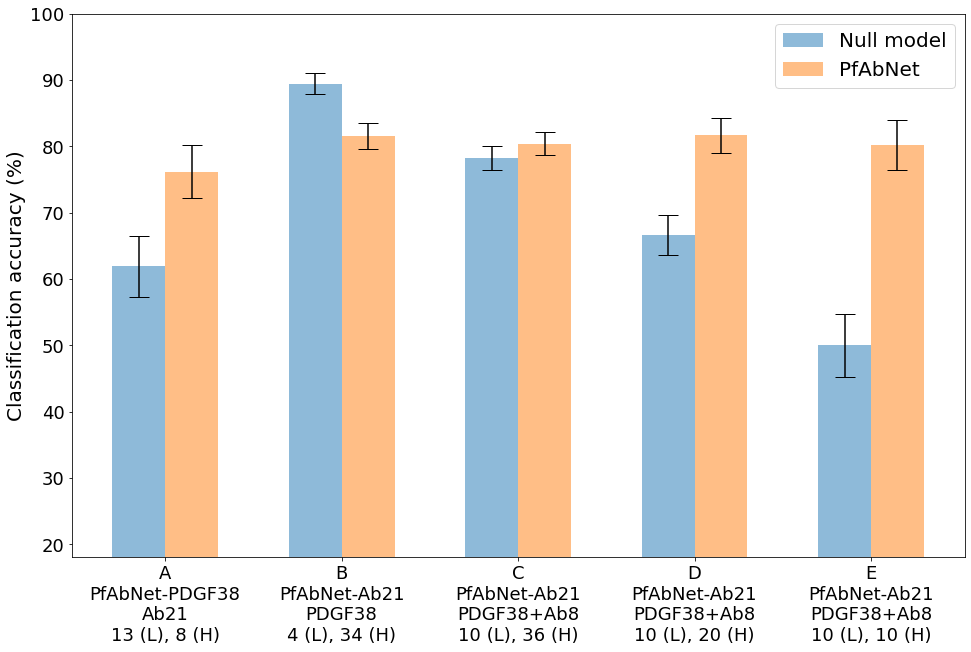

In [166]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(16*ncols,10*nrows))

np.random.seed(11)
df_pred = retrieve_prediction_outputs('models/ab21//*.csv')
df_ab8_pred = df_ab8.merge(df_pred, on=ENTITY_KEY)

df_pdgf38_ab8_pred = pd.concat([df_pdgf38_pred[[ENTITY_KEY, VISCOSITY_KEY, PfAbNet_SCORE_KEY]], 
                                df_ab8_pred[[ENTITY_KEY, VISCOSITY_KEY, PfAbNet_SCORE_KEY]]])

plot_pfabnet_vs_baseline_accuracy(axs, '', class_threshold=20, show_legend=True)
plt.savefig('Suppl_fig3.png', dpi=300)

### Performance of PfAbNet-Ab21 on PDGF38 + Ab8 dataset

Optimal operating point 21.56
Confusion matrix, without normalization
[[ 9  1]
 [ 8 28]]


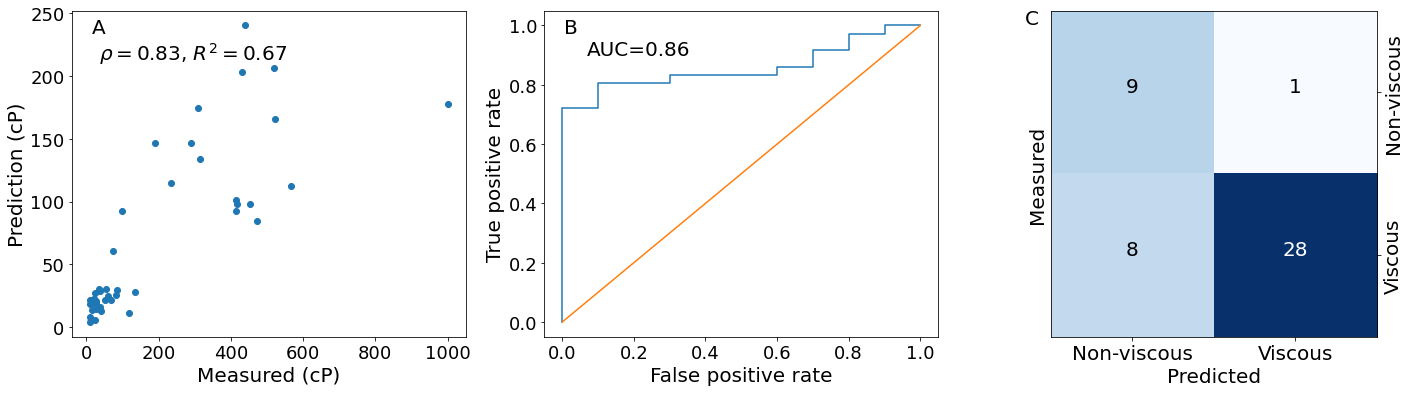

In [107]:
np.random.seed(11)

nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols,6*nrows))

generate_parity_plot(axs[0], df_pdgf38_ab8_pred[VISCOSITY_MES], df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 'A')
generate_roc_plot(axs[1], df_pdgf38_ab8_pred[VISCOSITY_MES], df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 'B')
generate_and_plot_confusion_matrix(axs[2], df_pdgf38_ab8_pred[VISCOSITY_MES], df_pdgf38_ab8_pred[PfAbNet_SCORE_KEY], 'C')

plt.savefig('Suppl_fig2.png', bbox_inches='tight', dpi=300)

### PfAbNet and baseline model predictions

### PDGF38 test set

In [48]:
df_pdgf38_pred_tbl = df_pdgf38_pred.copy()
df_pdgf38_pred_tbl[PfAbNet_SCORE_KEY] = df_pdgf38_pred_tbl[PfAbNet_SCORE_KEY].round(1)
df_pdgf38_pred_tbl = df_pdgf38_pred_tbl[[ENTITY_KEY, VISCOSITY_MES, PfAbNet_SCORE_KEY]]
df_pdgf38_pred_tbl.rename(columns={VISCOSITY_MES:'Expt. viscosity (150 mg/mL)', PfAbNet_SCORE_KEY:'PfAbNet-Ab21 prediction'}, inplace=True)
df_pdgf38_pred_tbl.head(n=38)

,Entity,Expt. viscosity (150 mg/mL),PfAbNet-Ab21 prediction
0,AB-001,440,240.3
1,R1-002,288,146.4
2,R1-003,523,165.6
3,R1-004,310,174.2
4,R1-005,190,147.0
5,R1-006,314,133.9
6,R1-007,233,115.0
7,R1-008,567,112.5
8,R1-009,430,202.9
9,R1-010,99,92.8


### Ab21 test set

In [47]:
df_ab21_pred_tbl = df_ab21_pred.merge(df_loocv_pred, on=ENTITY_KEY)
df_ab21_pred_tbl = df_ab21_pred_tbl.round(1)
df_ab21_pred_tbl = df_ab21_pred_tbl[[ENTITY_KEY, 'Viscosity_at_150_x', 'VISCOSITY_PRED_x', 'VISCOSITY_PRED_y']]
df_ab21_pred_tbl.rename(columns={'Viscosity_at_150_x':'Expt. viscosity (150 mg/mL)', 'VISCOSITY_PRED_x':'PfAbNet-Ab21 prediction', 
                                 'VISCOSITY_PRED_y':'PfAbNet-LOOCV prediction'}, inplace=True)
df_ab21_pred_tbl.head(n=21)

,Entity,Expt. viscosity (150 mg/mL),PfAbNet-Ab21 prediction,PfAbNet-LOOCV prediction
0,mAb1,14.4,73.6,34.2
1,mAb2,20.9,67.2,23.6
2,mAb3,14.9,120.2,34.6
3,mAb4,93.4,115.7,42.9
4,mAb5,8.6,71.8,39.6
5,mAb8,12.9,124.7,45.0
6,mAb10,10.2,15.2,8.0
7,mAb11,100.3,351.8,92.9
8,mAb12,7.5,31.0,17.7
9,mAb14,23.4,106.0,58.9


### Ab8 test set

In [56]:
df_ab8_pred_tbl = df_ab8_pred.copy()
df_ab8_pred_tbl[PfAbNet_SCORE_KEY] = df_ab8_pred_tbl[PfAbNet_SCORE_KEY].round(1)
df_ab8_pred_tbl = df_ab8_pred_tbl[[ENTITY_KEY, VISCOSITY_MES, PfAbNet_SCORE_KEY]]
df_ab8_pred_tbl.rename(columns={VISCOSITY_MES:'Expt. viscosity (150 mg/mL)', 
                                PfAbNet_SCORE_KEY: 'PfAbNet-Ab21 prediction'}, inplace=True)
df_ab8_pred_tbl.head(n=10)

,Entity,Expt. viscosity (150 mg/mL),PfAbNet-Ab21 prediction
0,TGN1412,16.42,13.7
1,Basiliximab,25.05,14.2
2,Natalizumab,13.67,20.4
3,Tremelimumab,8.80,4.1
4,Ipilimumab,8.60,8.0
5,Atezolizumab,11.56,19.5
6,Ganitumab,10.10,18.4
7,Vesencumab,23.57,5.8
